# SVM
### Podejście klasyczne vs kwantowe

Przedstaw wybrany problem biznesowy (problem ten określamy opisując czy to problem nadzorowany czy nienadzorowany, jakiego zagadnienia dotyczy i krótkie omówienie danych poprzez EDA. 

Przedstaw zaproponowane klasyczne rozwiązanie problemu 

Przedstaw sposób kodowania danych (jeśli potrzebne) 

Przedstaw przetworzony ansatz (dobrze zweryfikować kilka wersji) 

Porównaj wyniki modeli kwantowych i klasycznych. Oprócz statystyk przedstaw info o ilości parametrów i czasie obliczeń. 

### Problem Biznesowy

Problem dotyczy przewidywania odejścia klientów (churn) w firmie telekomunikacyjnej. Jest to problem nadzorowany, ponieważ mamy etykiety wskazujące, czy klient odszedł, czy nie. Celem jest zbudowanie modelu, który na podstawie danych historycznych będzie przewidywał, czy dany klient odejdzie.

Dane zawierają informacje o klientach, takie jak czas trwania umowy, rodzaj usługi, demografia, oraz czy klient odszedł. Przeprowadzimy eksploracyjną analizę danych (EDA), aby lepiej zrozumieć strukturę danych i zidentyfikować potencjalne cechy wpływające na odejście klientów.

### Paczki

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import pennylane as qml

### Zbiór danych

In [2]:
# Wczytanie danych
train_data = pd.read_csv('CUSTOMER_CHURN_DATASET-TRAINING-MASTER.CSV')
test_data = pd.read_csv('CUSTOMER_CHURN_DATASET-TESTING-MASTER.CSV')

In [3]:
# Podstawowe informacje o danych
print(train_data.info())
print(train_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB
None
          CustomerID            Age         Tenure  Usage Frequency  \
count  440832.000000  440832.000000  440832.000000    440832.000000   
mea

In [4]:
print(train_data.shape) #87.5%

(440833, 12)


In [5]:
print(test_data.shape) #12.5%

(64374, 12)


In [6]:
print(train_data.head())

   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0             Basic         Monthly        617.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0    1.0  
3              29.0    1.0  
4              20.0    1.

### Eksploracyjna Analiza Danych (EDA) 

In [7]:
# Sprawdzenie brakujących wartości
print(train_data.isnull().sum())

CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64


In [8]:
#Sprawdzenie indeksu brakującej wartości
print(train_data[train_data['Age'].isna()])

        CustomerID  Age Gender  Tenure  Usage Frequency  Support Calls  \
199295         NaN  NaN    NaN     NaN              NaN            NaN   

        Payment Delay Subscription Type Contract Length  Total Spend  \
199295            NaN               NaN             NaN          NaN   

        Last Interaction  Churn  
199295               NaN    NaN  


In [9]:
train_data = train_data.drop(199295)
train_data = train_data.reset_index(drop = True)

In [10]:
#Usunięcie niepotrzebnej zmiennej CustomerID
train_data = train_data.drop(columns = 'CustomerID')
test_data = test_data.drop(columns = 'CustomerID')

In [11]:
train_data['Subscription Type'].isnull().sum()

0

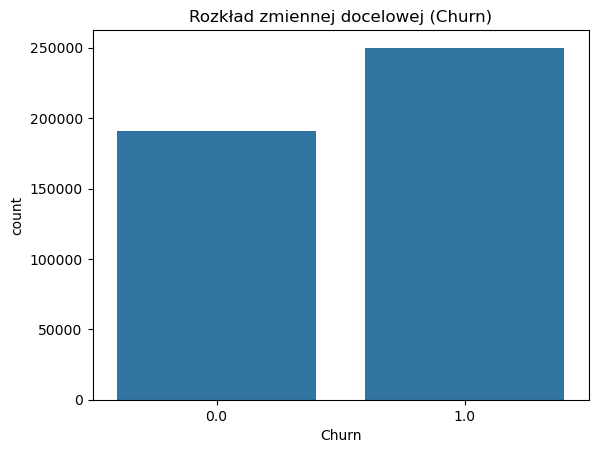

Churn
1.0    249999
0.0    190833
Name: count, dtype: int64


In [12]:
# Rozkład zmiennej docelowej
sns.countplot(x='Churn', data=train_data)
plt.title('Rozkład zmiennej docelowej (Churn)')
plt.show()
print(train_data['Churn'].value_counts())

Zbiór jest lekko niezbilansowany -> SVM jest mniej wrażliwe na niezbilansowanie

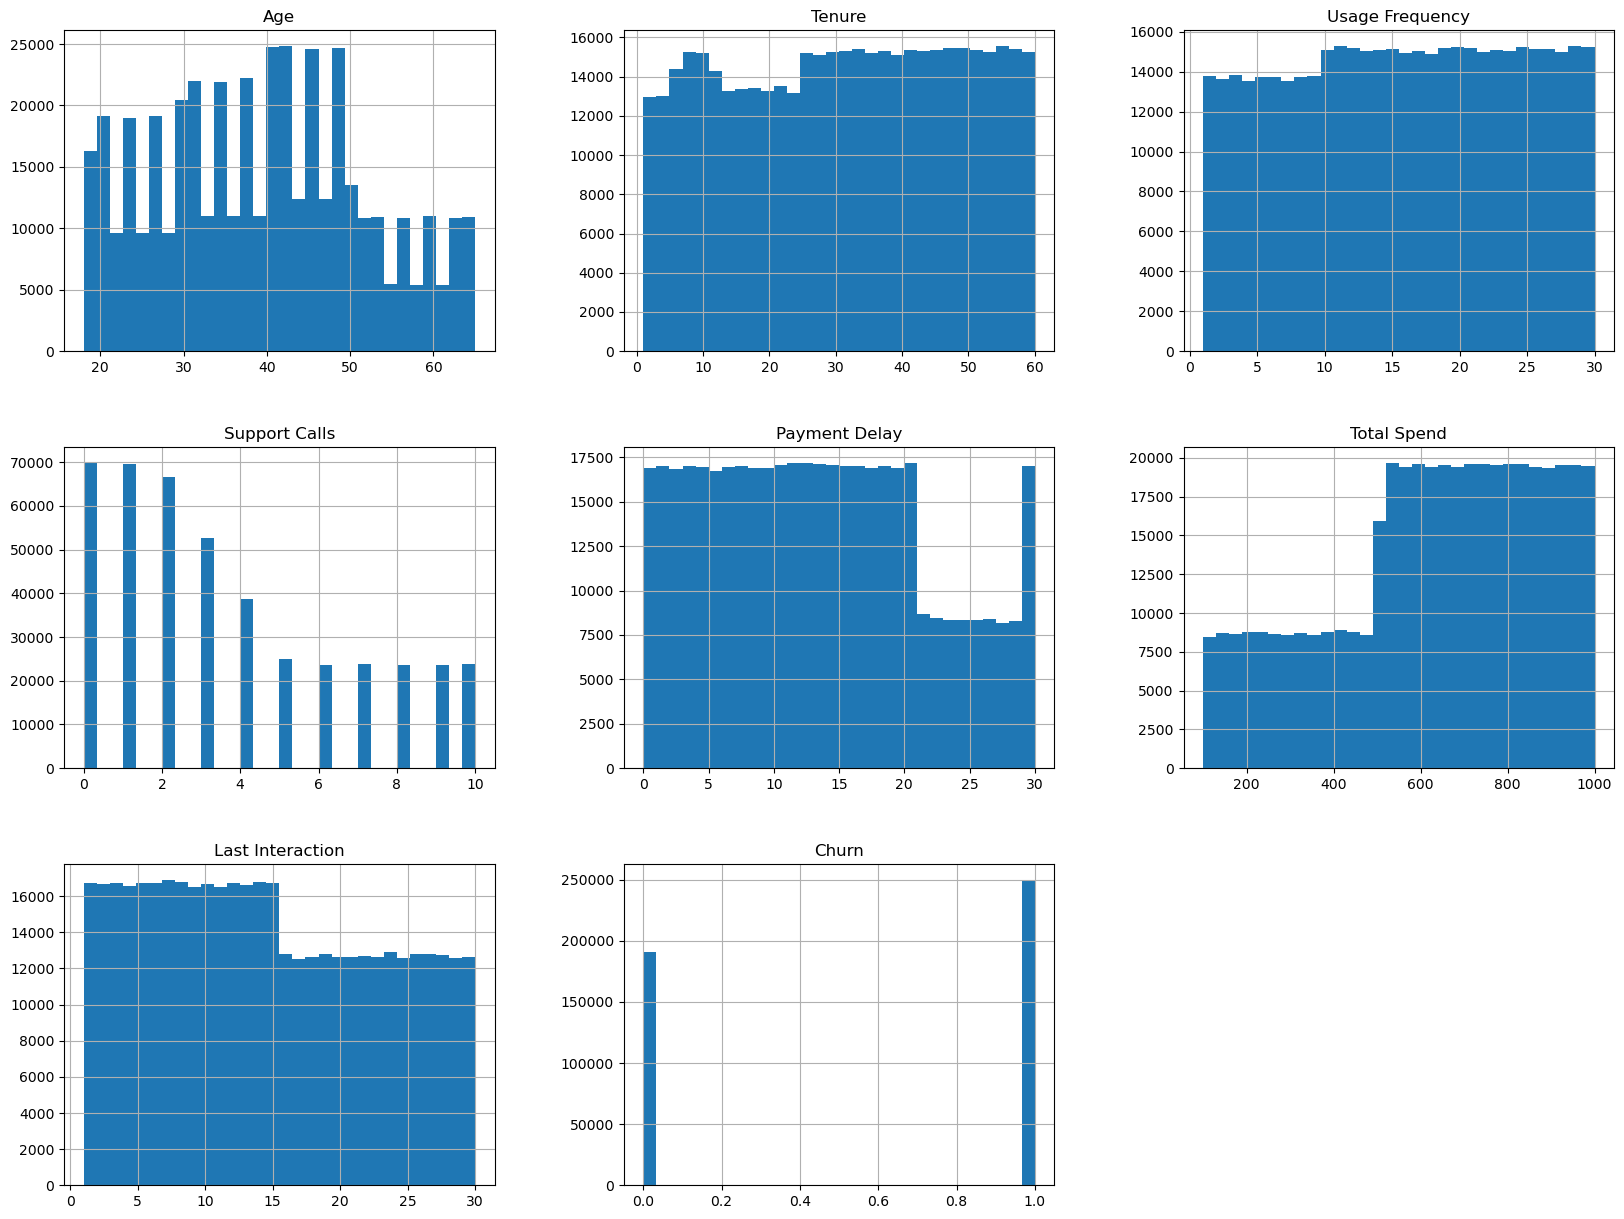

In [13]:
# Rozkład cech numerycznych
train_data.hist(bins=30, figsize=(20, 15))
plt.show()

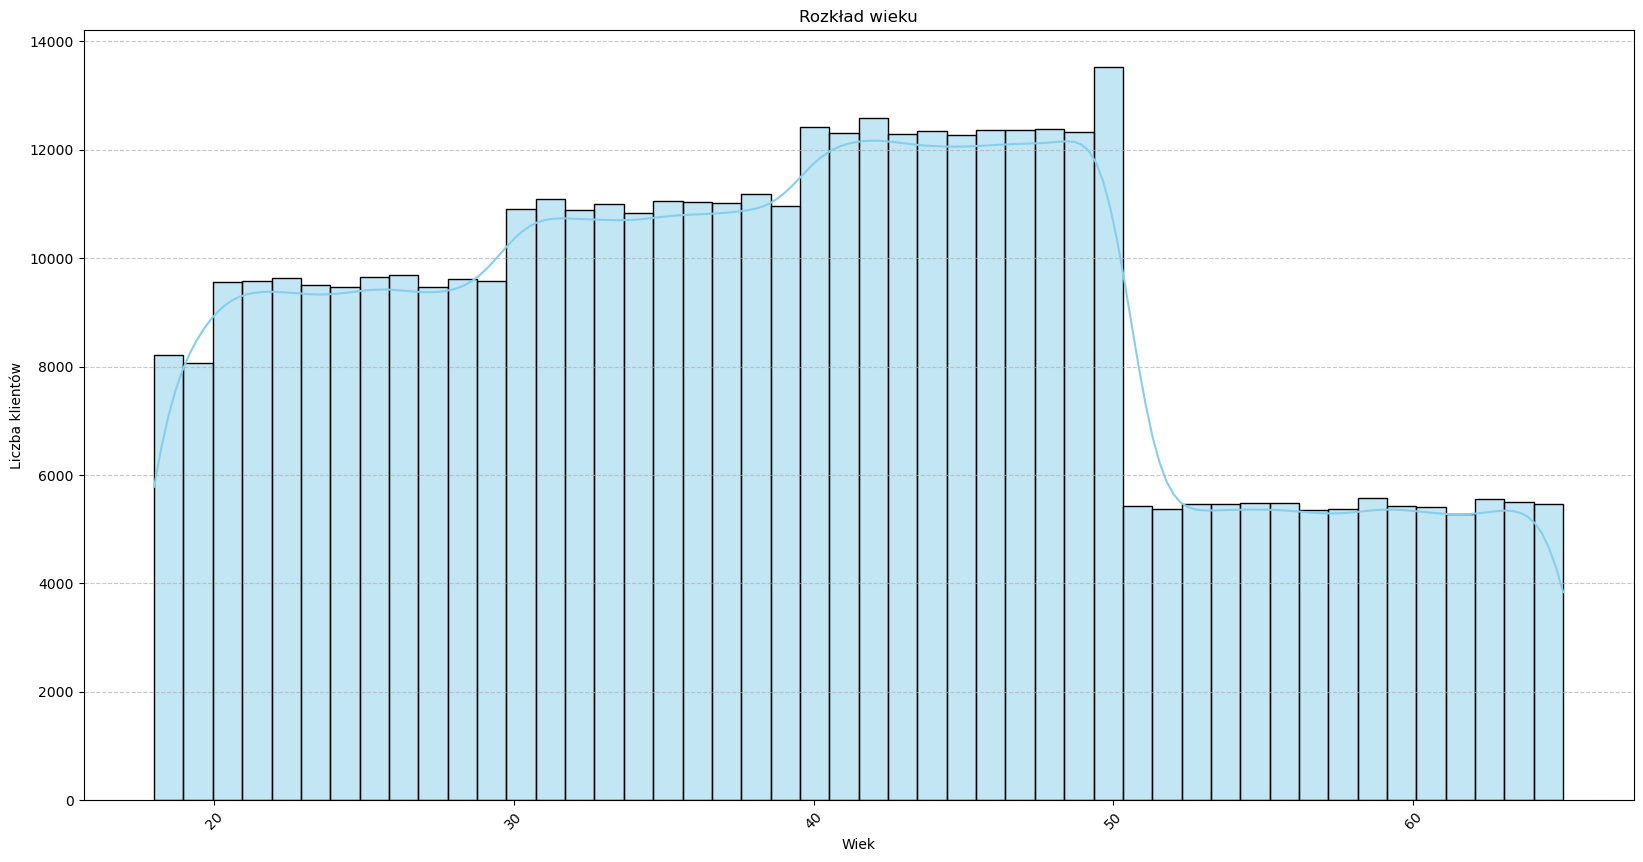

In [14]:
#Rozkład wieku
plt.show()
plt.figure(figsize=(20, 10))
sns.histplot(train_data['Age'], bins=48, kde=True, color='skyblue')
plt.title('Rozkład wieku')
plt.xlabel('Wiek')
plt.ylabel('Liczba klientów')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

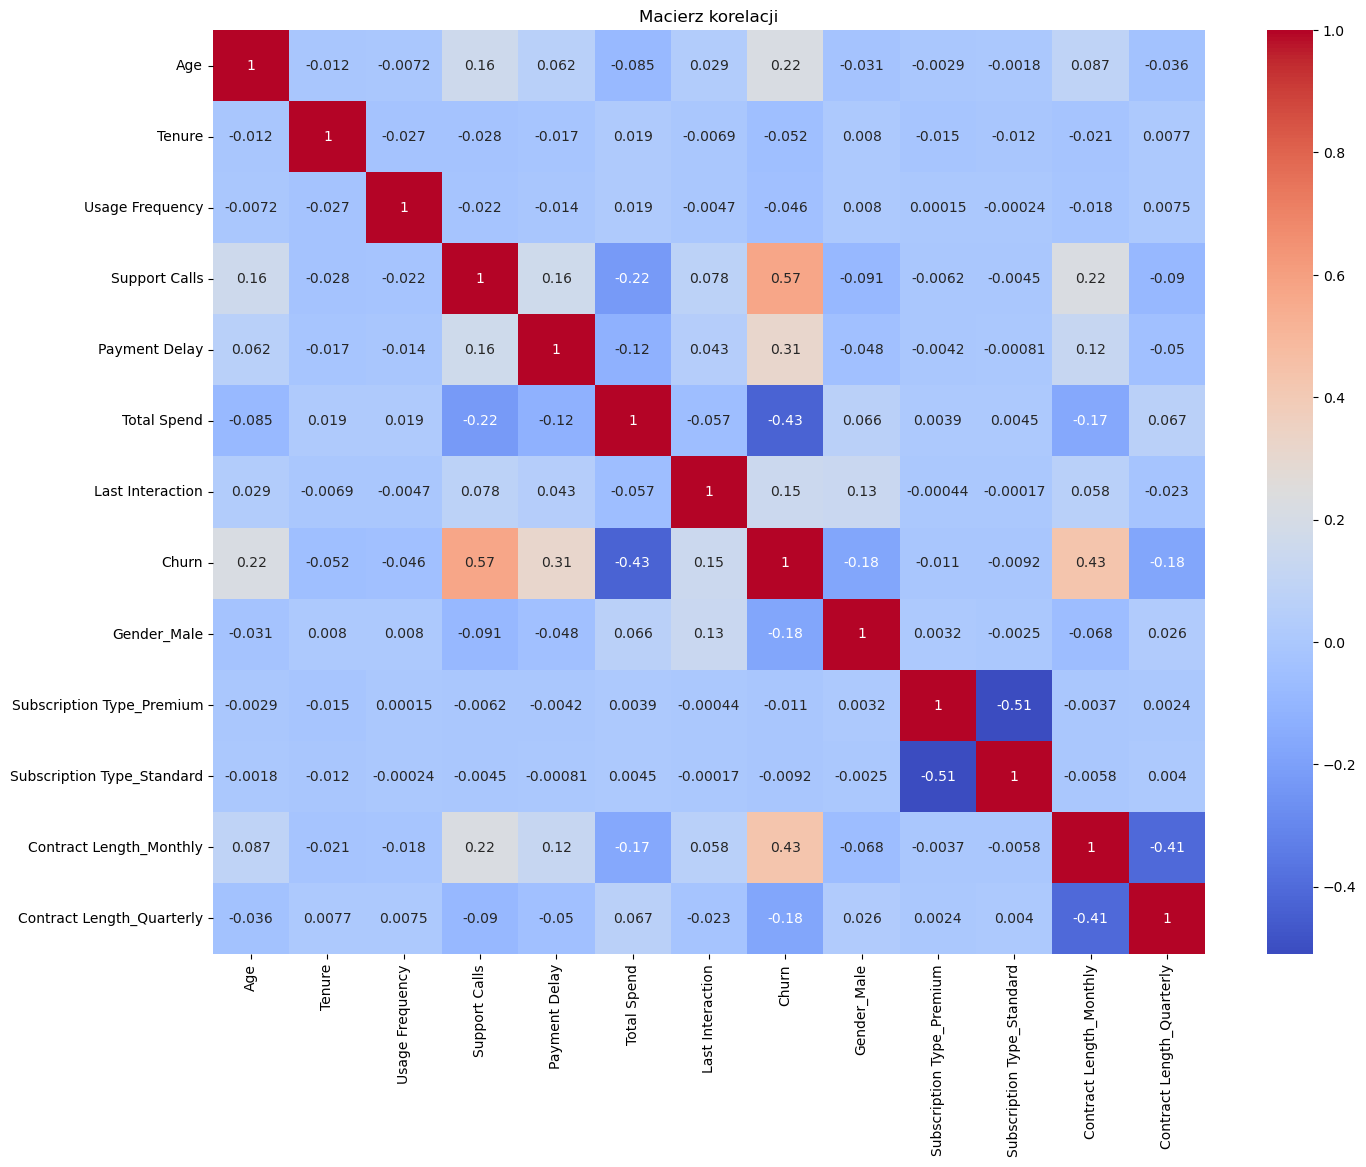

In [15]:
# Konwersja zmiennych kategorycznych na numeryczne
train_data_encoded = pd.get_dummies(train_data, drop_first=True)

# Korelacja między cechami
corr_matrix = train_data_encoded.corr()
plt.figure(figsize=(16, 12))  # Zwiększenie rozmiaru wykresu
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Macierz korelacji')
plt.show()

In [16]:
# Generowanie tabeli ze statystykami opisowymi
desc_stats = train_data.describe().transpose()
desc_stats['missing_values'] = train_data.isnull().sum()
desc_stats['unique_values'] = train_data.nunique()

# Zaokrąglenie wartości do dwóch miejsc po przecinku
desc_stats = desc_stats.round(2)

# Usunięcie pustych rozwinięć dziesiętnych
desc_stats = desc_stats.map(lambda x: int(x) if x == int(x) else x)

desc_stats

# Eksportowanie tabeli do pliku Excel
#desc_stats.to_excel('desc_stats.xlsx', index=True)

,count,mean,std,min,25%,50%,75%,max,missing_values,unique_values
Age,440832,39.37,12.44,18,29,39,48,65,0,48
Tenure,440832,31.26,17.26,1,16,32,46,60,0,60
Usage Frequency,440832,15.81,8.59,1,9,16,23,30,0,30
Support Calls,440832,3.60,3.07,0,1,3,6,10,0,11
Payment Delay,440832,12.97,8.26,0,6,12,19,30,0,31
Total Spend,440832,631.62,240.80,100,480,661,830,1000,0,68363
Last Interaction,440832,14.48,8.60,1,7,14,22,30,0,30
Churn,440832,0.57,0.50,0,0,1,1,1,0,2


### Sposób Kodowania Danych

Kodowanie danych jest procesem przekształcania danych kategorycznych na format numeryczny, który może być używany przez algorytmy uczenia maszynowego. W naszym przypadku, aby odpowiedzieć na pytanie, czy kodowanie jest wymagane, musimy przeanalizować dane i zidentyfikować kolumny kategoryczne.


In [17]:
# Podstawowe informacje o danych
print(train_data.info())

# Wyświetlenie pierwszych kilku wierszy danych
print(train_data.head())

# Sprawdzenie unikalnych wartości w każdej kolumnie
for column in train_data.columns:
    print(f"{column}: {train_data[column].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440832 entries, 0 to 440831
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  float64
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  float64
 3   Usage Frequency    440832 non-null  float64
 4   Support Calls      440832 non-null  float64
 5   Payment Delay      440832 non-null  float64
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  float64
 10  Churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 37.0+ MB
None
    Age  Gender  Tenure  Usage Frequency  Support Calls  Payment Delay  \
0  30.0  Female    39.0             14.0            5.0           18.0   
1  65.0  Female    49.0              1.0      

## Wstępne Przygotowanie Danych 

Wczytanie danych treningowych i testowych.
Identyfikacja i kodowanie zmiennych kategorycznych.
Podział danych na cechy (X) i etykiety (y).

In [18]:
# Identyfikacja kolumn kategorycznych
categorical_columns_no_order = ['Gender']
categorical_columns_with_order = ['Subscription Type', 'Contract Length']

# Sprawdzenie brakujących wartości przed kodowaniem
print("Brakujące wartości przed kodowaniem w danych treningowych:")
print(train_data.isnull().sum())
print("\nBrakujące wartości przed kodowaniem w danych testowych:")
print(test_data.isnull().sum())

# One-Hot Encoding dla kolumn bez relacji porządkowych
encoder = OneHotEncoder(sparse_output=False)
encoded_columns_no_order_train = encoder.fit_transform(train_data[categorical_columns_no_order])
encoded_columns_no_order_test = encoder.transform(test_data[categorical_columns_no_order])

# Label Encoding dla kolumn z relacjami porządkowymi
label_encoders = {}
for col in categorical_columns_with_order:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])
    label_encoders[col] = le

# Konwersja zakodowanych kolumn do DataFrame
encoded_df_no_order_train = pd.DataFrame(encoded_columns_no_order_train, columns=encoder.get_feature_names_out(categorical_columns_no_order))
encoded_df_no_order_test = pd.DataFrame(encoded_columns_no_order_test, columns=encoder.get_feature_names_out(categorical_columns_no_order))

Brakujące wartości przed kodowaniem w danych treningowych:
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

Brakujące wartości przed kodowaniem w danych testowych:
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64


In [19]:
# Usunięcie oryginalnych kolumn kategorycznych i dodanie zakodowanych kolumn
train_data_encoded = train_data.drop(categorical_columns_no_order + categorical_columns_with_order, axis=1)
train_data_encoded = pd.concat([train_data_encoded, encoded_df_no_order_train], axis=1)

test_data_encoded = test_data.drop(categorical_columns_no_order + categorical_columns_with_order, axis=1)
test_data_encoded = pd.concat([test_data_encoded, encoded_df_no_order_test], axis=1)

# Sprawdzenie brakujących wartości po kodowaniu
print("\nBrakujące wartości po kodowaniu w danych treningowych:")
print(train_data_encoded.isnull().sum())
print("\nBrakujące wartości po kodowaniu w danych testowych:")
print(test_data_encoded.isnull().sum())

# Sprawdzenie, czy wszystkie kolumny kategoryczne zostały poprawnie zakodowane
def check_encoding(train_data_encoded, test_data_encoded, categorical_columns_no_order, categorical_columns_with_order):
    # Sprawdzenie, czy zakodowane kolumny nie zawierają brakujących wartości
    if train_data_encoded.isnull().sum().sum() == 0 and test_data_encoded.isnull().sum().sum() == 0:
        print("Brak brakujących wartości w zakodowanych kolumnach.")
    else:
        print("Istnieją brakujące wartości w zakodowanych kolumnach.")
    
    # Sprawdzenie, czy wszystkie kolumny kategoryczne zostały zakodowane
    for col in categorical_columns_no_order:
        if col in train_data_encoded.columns or col in test_data_encoded.columns:
            print(f"Kolumna {col} nie została poprawnie zakodowana.")
        else:
            print(f"Kolumna {col} została poprawnie zakodowana.")
    
    for col in categorical_columns_with_order:
        if col in train_data_encoded.columns or col in test_data_encoded.columns:
            print(f"Kolumna {col} nie została poprawnie zakodowana.")
        else:
            print(f"Kolumna {col} została poprawnie zakodowana.")

# Wywołanie funkcji sprawdzającej
check_encoding(train_data_encoded, test_data_encoded, categorical_columns_no_order, categorical_columns_with_order)


Brakujące wartości po kodowaniu w danych treningowych:
Age                 0
Tenure              0
Usage Frequency     0
Support Calls       0
Payment Delay       0
Total Spend         0
Last Interaction    0
Churn               0
Gender_Female       0
Gender_Male         0
dtype: int64

Brakujące wartości po kodowaniu w danych testowych:
Age                 0
Tenure              0
Usage Frequency     0
Support Calls       0
Payment Delay       0
Total Spend         0
Last Interaction    0
Churn               0
Gender_Female       0
Gender_Male         0
dtype: int64
Brak brakujących wartości w zakodowanych kolumnach.
Kolumna Gender została poprawnie zakodowana.
Kolumna Subscription Type została poprawnie zakodowana.
Kolumna Contract Length została poprawnie zakodowana.


Zastosowanie kodowania One-Hot jest uzasadnione w naszym przypadku, ponieważ pozwala nam konwertować zmienne kategoryczne na format numeryczny odpowiedni dla algorytmów uczenia maszynowego. Zastosowanie kodowania LabelEncoder pozwala zachować relacje porządkowe. 

Zmienną kategoryczną bez relacji porządkowej jest **Gender**

Zmiennymi kategorycznymi z relacjami porządkowymi są **Subscription Type** ['Basic', 'Standard', 'Premium'] oraz **Contract Length** ['Monthly', 'Quarterly', 'Annual']

In [20]:
# Podział danych na cechy (X) i etykiety (y)
X_train = train_data_encoded.drop(['Churn', 'Gender_Female'], axis=1)
y_train = train_data_encoded['Churn']

X_test = test_data_encoded.drop(['Churn', 'Gender_Female'], axis=1)
y_test = test_data_encoded['Churn']

### Normalizacja danych
Normalizacja danych do zakresu [-1, 1] zapobiega problemom z niestabilnymi obliczeniami i błędami numerycznymi w kwantowych obwodach.

Wiele algorytmów (w tym - kwantowych) są zaprojektowane do pracy z danymi w określonym zakresie, a normalizacja zapewnia zgodność danych z wymaganiami tych algorytmów.

In [21]:
# Normalizacja danych
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model klasyczny regresji logistycznej z scikit-learn

In [24]:
start_time = time.time()  
sk_log_reg = LogisticRegression()
sk_log_reg.fit(X_train_scaled, y_train)
end_time = time.time() 
elapsed_time = (end_time - start_time)/60 
print(f"Elapsed time: {elapsed_time:.2f} minutes")
y_pred = sk_log_reg.predict(X_test_scaled)
sk_lr_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy regresji logistycznej: {sk_lr_accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Elapsed time: 0.01 minutes
Accuracy regresji logistycznej: 0.59

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.23      0.37     33881
           1       0.53      0.98      0.69     30493

    accuracy                           0.59     64374
   macro avg       0.74      0.61      0.53     64374
weighted avg       0.75      0.59      0.52     64374



## Model klasyczny regresji logistycznej z scikit-learn (GridSearchCV)

In [55]:
#Siatka parametrów
start_time = time.time()  
param_grid = {
    'penalty': ['l1', 'l2', None],
    'C': [0.01, 0.1, 1, 10, 100]
}
log_reg = LogisticRegression(max_iter=10000, solver='saga')
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
end_time = time.time() 
elapsed_time = (end_time - start_time)/60 
print(f"Elapsed time: {elapsed_time:.2f} minutes")
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Elapsed time: 1.97 minutes
Best Parameters: {'C': 0.01, 'penalty': 'l2'}
Best Cross-Validation Score: 0.8512381181254314


In [60]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
grid_lr_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy regresji logistycznej: {grid_lr_accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy regresji logistycznej: 0.59

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.23      0.37     33881
           1       0.54      0.98      0.69     30493

    accuracy                           0.59     64374
   macro avg       0.74      0.61      0.53     64374
weighted avg       0.75      0.59      0.52     64374



In [61]:
num_features = best_model.coef_.shape[1]
print(f"Total number of parameters: {num_features+1}")

Total number of parameters: 9


Przyczyną niskiej dokładności może być zbyt mały zbiór testowy (podział 87.5% na 12.5%). Celem modelu jest wyłapanie tych, co odejdą, czyli recall dla klasy 1. Model klasyfikuje więcej churnerów niż w rzeczywistości (niska precyzja - 0.53) oraz źle prognozuje tych, co nie odejdą (recall - 0.23). Jest to akceptowalne, biorąc pod uwagę cel biznesowy. 

## Model klasyczny SVM z scikit-learn

In [27]:
start_time = time.time()  
sk_svm = SVC(random_state=42)
sk_svm.fit(X_train_scaled, y_train)
end_time = time.time() 
elapsed_time = (end_time - start_time)/60 
print(f"Elapsed time: {elapsed_time:.2f} minutes")
y_pred2 = sk_svm.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred2))
print("\nClassification Report:")
print(classification_report(y_test, y_pred2))

Elapsed time: 26.80 minutes
0.5409326746823252

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.13      0.23     33881
           1       0.51      0.99      0.67     30493

    accuracy                           0.54     64374
   macro avg       0.73      0.56      0.45     64374
weighted avg       0.75      0.54      0.44     64374



In [29]:
print(f"Number of support vectors: {len(sk_svm.support_)}")
print(f"Number of support vectors per class: {sk_svm.n_support_}")

Number of support vectors: 53834
Number of support vectors per class: [26978 26856]


----------------

## Przygotowanie danych do kwantowego uczenia maszynowego


1. **Definicja Ansatz**
Zdefiniowanie ansatz, czyli parametryzowanego kwantowego obwodu, który będzie używany w modelu kwantowego SVM.

2. **Definicja Modelu Kwantowego SVM**
Implementacja kwantowego SVM z użyciem biblioteki PennyLane.
Definicja funkcji kosztu i optymalizatora.

3. **Trening Modelu**
Trening modelu kwantowego SVM na danych treningowych.
Monitorowanie procesu treningu i zapisywanie wyników.

4. **Ewaluacja Modelu**
Ewaluacja modelu na danych testowych.
Obliczenie metryk wydajności, takich jak dokładność, precyzja, recall, F1-score.

5. **Porównanie z Modelem Klasycznym**
Porównanie wyników modelu kwantowego SVM z klasycznym SVM.
Analiza liczby parametrów i czasu obliczeń dla obu modeli.

In [22]:
def prepare_data_for_qsvm(X_train_df, X_test_df):
    #Skalowanie
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_train_df_scaled = scaler.fit_transform(X_train_df)
    X_test_df_scaled = scaler.transform(X_test_df)
    
    #Kwantowe przeliczenie
    X_trainQ = np.asarray(X_train_df_scaled)
    X_testQ = np.asarray(X_test_df_scaled)
    
    return X_trainQ, X_testQ, scaler

X_trainQ, X_testQ, scaler = prepare_data_for_qsvm(X_train, X_test)

print("X_trainQ shape:", X_trainQ.shape)
print("X_testQ shape:", X_testQ.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_trainQ shape: (440832, 8)
X_testQ shape: (64374, 8)
y_train shape: (440832,)
y_test shape: (64374,)


In [23]:
sample_size = 1000
X_trainQ_small = X_trainQ[:sample_size]
y_train_small = y_train[:sample_size]
X_testQ_small = X_testQ[:sample_size]
y_test_small = y_test[:sample_size]

----------------

## Model kwantowy regresja logistyczna z PyTorch i Pennylane 

In [62]:
n_qubits = len(X_trainQ[0]) 
dev = qml.device('default.qubit', wires=n_qubits)

projector = np.zeros((2 ** n_qubits, 2 ** n_qubits))
projector[0, 0] = 1

@qml.qnode(dev)
def quantum_model(x, params):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits))) #pomiar globalny

def quantum_model_plus_bias(x, params, bias):
    return quantum_model(x, params) + bias

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def logistic_loss(predictions, targets):
    predictions = sigmoid(predictions)  #Uzyskanie prawdopodobienstw
    loss = -targets * torch.log(predictions) - (1 - targets) * torch.log(1 - predictions)
    return loss

In [63]:
def quantum_model_train_logistic(n_layers, steps, batch_size):
    params = np.random.random((n_layers, n_qubits, 3)) #losowe parametry
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0, requires_grad=True)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):
        batch_ids = np.random.choice(len(X_trainQ), batch_size)
        X_batch = X_trainQ[batch_ids]
        y_batch = y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch.values, requires_grad=False).float()  

        def closure():
            opt.zero_grad()
            
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
            )
            
            loss = torch.mean(logistic_loss(preds, y_batch_torch))

            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            #Propagacja wsteczna
            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history

In [64]:
def quantum_model_predict_logistic(X_pred, trained_params, trained_bias):
    
    p = []
    for x in X_pred:
        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        prob = sigmoid(pred_torch).detach().numpy().item()  # Convert raw output to probability
        
        # Assign class label based on threshold 0.5
        if prob >= 0.5:
            label = 1
        else:
            label = 0
        
        p.append(label)
    return p

In [ ]:
start_time = time.time() 
n_layers = 2
batch_size = 20
steps = 100

with dev.tracker:
    trained_params, trained_bias, loss_history = quantum_model_train_logistic(n_layers, steps, batch_size)
    pred_test = quantum_model_predict_logistic(X_testQ, trained_params, trained_bias)
end_time = time.time() 
elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.2f} minutes")
print("accuracy on test set:", accuracy_score(pred_test, y_test))
print("\nClassification Report:")
print(classification_report(y_test, pred_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

step 0 , loss 0.6795622350029306
step 10 , loss 0.6580550196970052
step 20 , loss 0.6583220311285433
step 30 , loss 0.6388909507924748
step 40 , loss 0.6542176035945386
step 50 , loss 0.7185666144996901
step 60 , loss 0.652704566745645
step 70 , loss 0.6177686659299182
step 80 , loss 0.6517762293124153
step 90 , loss 0.6644569101365011


----------------

## Model kwantowy SVM

Definiowane jest urządzenie kwantowe, gdzie liczba kubitów jest określana na podstawie kształtu danych wejściowych (X_train_scaled). 

Tworzony jest kwantowy symulator 'default.qubit' z określoną liczbą kubitów. Kolejnym krokiem jest definiowanie ansatz. 

Funkcja ansatz jest definiowana jako węzeł kwantowy (qnode), który przyjmuje wagi i opcjonalne dane wejściowe (x). Szablon AngleEmbedding osadza dane wejściowe w obwodzie kwantowym za pomocą bramek rotacyjnych.

Funkcja zwraca wartość oczekiwaną operatora PauliZ na pierwszym kubicie (czyli jest to pomiar lokalny).

In [25]:
# Definicja urządzenia kwantowego
n_qubits = len(X_trainQ_small[0]) #X_trainQ_small.shape[1]
dev = qml.device('default.qubit', wires=n_qubits)

# Definicja ansatz
@qml.qnode(dev)
def kernel_circuit(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))
#Kwantyfikator 
def quantum_kernel_matrix(X1, X2):
    K = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            K[i, j] = kernel_circuit(X1[i], X2[j])
    return K

In [26]:
start_time = time.time() 
#K_trainQ = quantum_kernel_matrix(X_trainQ_small, X_trainQ_small)
#K_testQ = quantum_kernel_matrix(X_testQ_small, X_trainQ_small)
clf = SVC(kernel=quantum_kernel_matrix) #kernel='precomputed'
clf.fit(X_trainQ_small, y_train_small)
end_time = time.time() 
elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.2f} minutes")

Elapsed time: 56.01 minutes


In [27]:
y_pred_q = clf.predict(X_testQ_small)
#q_svm_accuracy = accuracy_score(y_test_small, y_pred_q)
print(accuracy_score(y_test_small, y_pred_q))
print("\nClassification Report:")
print(classification_report(y_test_small, y_pred_q))

0.242

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       758
           1       0.24      1.00      0.39       242

    accuracy                           0.24      1000
   macro avg       0.12      0.50      0.19      1000
weighted avg       0.06      0.24      0.09      1000



D:\Programowanie\Python\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Programowanie\Python\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Programowanie\Python\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
print(f"Number of support vectors: {len(clf.support_)}")
print(f"Number of support vectors per class: {clf.n_support_}")

Number of support vectors: 68
Number of support vectors per class: [34 34]
